In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys

In [2]:
sys.path.append('..')

In [3]:
from ers.base import ERS
from ers.models import NonLinearAR

In [4]:
T = 100
alpha=0.9
sv=0.3
sw=0.1
d=2

model = NonLinearAR(dimension=d, alpha=alpha, sv=sv, sw=sw)

In [5]:
xtrue = np.zeros((T,d))
y = np.zeros((T,d))

xtrue[0,:] = np.random.randn(d)
y[0] = xtrue[0]+sw*np.random.randn(1);

for t in range(2,T):
    xtrue[t] = alpha * np.tanh(xtrue[t-1]) + sv * np.random.randn(d)
    y[t] = xtrue[t] + sw * np.random.randn(d)

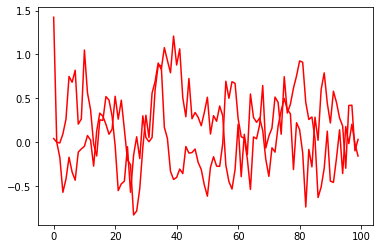

In [6]:
plt.plot(xtrue, color = 'red')

In [7]:
n_samples = 2
accepted_x, cand_x, n_trial = model.sample_n(n_samples=n_samples, n_particles=2500, T=T, y=y)

100%|██████████| 2/2 [01:58<00:00, 59.46s/it]


In [8]:
n_samples/ n_trial

0.5

In [9]:
average_x = np.mean(accepted_x, axis=0)

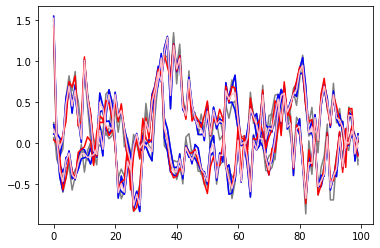

In [10]:
for i in range(cand_x.shape[0]):
    plt.plot(cand_x[i,:,:], color = 'gray')
    
for i in range(accepted_x.shape[0]):
    plt.plot(accepted_x[i,:,:], color = 'blue')

plt.plot(xtrue, color = 'red')
plt.plot(average_x, color = 'pink')

In [11]:
 from pathos.multiprocessing import ProcessingPool as Pool

In [12]:
import time

In [ ]:
# run in parallel
start = time.time()
num_workers = 3
n_samples = 100
n_particles = 2000
f = lambda x : model.sample_n(n_samples=n_samples, n_particles=n_particles, T=T, y=y)
with Pool(num_workers) as p:
        out = p.map(f, range(num_workers))
time.time()-start

 33%|███▎      | 33/100 [1:16:35<1:50:27, 98.92s/it] 

In [ ]:
accepted_x = np.concatenate([out[i][0] for i in range(num_workers)])
cand_x = np.concatenate([out[i][1] for i in range(num_workers)])
average_x = np.mean(accepted_x, axis=0)

In [ ]:
for i in range(cand_x.shape[0]):
    plt.plot(cand_x[i,:,0], color = 'gray')
    
for i in range(accepted_x.shape[0]):
    plt.plot(accepted_x[i,:,0], color = 'blue')

plt.plot(xtrue[:,0], color = 'red')
plt.plot(average_x[:,0], color = 'pink')

In [ ]:
from PIL import Image
import shutil


accepted_x, cand_x, n_trial = model.sample_n(n_samples=1, n_particles=1000, T=T, y=y)

number_trials = cand_x.shape[0]

In [ ]:
fig, ax = plt.subplots()

plt.ylim(-1.1,1.1)
ax.plot([], color = 'gray', label = 'Proposal')
ax.plot([], color = 'blue', label = 'Accepted')
ax.plot(xtrue[:,0], color = 'red', label = 'True latent state')

In [ ]:

gif_dir = './gif_dir'
if os.path.isdir(gif_dir):
    shutil.rmtree(gif_dir) 
os.mkdir(gif_dir)

j = 0

fig, ax = plt.subplots()

plt.ylim(-1.1,1.1)
ax.plot([], color = 'gray', label = 'Proposal')
ax.plot([], color = 'blue', label = 'Accepted')
ax.plot(xtrue[:,0], color = 'red', label = 'True latent state')
ax.legend()
plt.savefig(os.path.join(gif_dir,'plot_{0}.png'.format(-1)))


for i in range(number_trials):
    plt.ylim(-1.1,1.1)
    ax.plot(xtrue[:,0], color = 'red', label = 'True latent state')
    ax.plot(cand_x[i,:,0], color = 'gray',label = 'Proposal')
    if (cand_x[i,:,0]==accepted_x[j,:,0]).all():
        ax.plot(accepted_x[0,:,0], color = 'blue', label = 'Accepted')
        j += 1
    plt.savefig(os.path.join(gif_dir,'plot_{0}.png'.format(i)))
    
    

In [ ]:
fps = [os.path.join('./gif_dir', 'plot_{0}.png'.format(t)) for t in range(-1,number_trials)]
frames = [Image.open(fn) for fn in fps]
frames[0].save('nonlinearar.gif', format='GIF', append_images=frames[1:], save_all=True, duration=100, loop=0)

![](nonlinearar.gif)